# **多元卡尔曼滤波器**

过滤多个随机变量

In [1]:
%matplotlib inline

#format the book
import lean.book_format as book_format
book_format.set_style()

## **介绍**

我们现在准备研究和实现完整的多元形式的卡尔曼滤波器。在上一章中，我们学会了如何用多元高斯表达多个随机变量之间的相关性，例如飞机的位置和速度。我们也了解了变量之间的相关性如何显著的改变后验估计。如果我们只是粗略知道飞机的位置和速度，但是它们是相关的，那么我们新的估计值是可以非常准确的。

我更喜欢通过几个工作示例让你对滤波器原理产生直觉感受。我将会掩盖很多不必要的问题。我向您展示的某些内容仅适用于特殊情况，而其他内容则“神奇”-不清楚我是如何得出某个结果的。如果我从严格的、广义的方程开始，你会对所有这些术语的含义以及如何将它们应用于你的问题感到挠头。在后面的章节中，我将提供一个更严格的数学基础，届时我将不得不纠正我在本章中所做的近似值，或者提供我在这里没有涉及的其他信息。

为了实现这一目标，我们将自己限制在可以用牛顿运动方程描述的问题子集上。这些滤波器称为离散化连续时间运动滤波器。在卡尔曼滤波数学一章中，我们将开发非牛顿系统的数学。

## **牛顿运动方程**

牛顿的运动方程告诉我们，给定一个系统的恒定速度 𝑣 ，我们可以计算出它在时间 𝑡 后的位置 𝑥 ：

$$x = vt + x_0$$

例如，如果我们从位置 13 开始，我们的速度是 10 m/s，我们行进 12 秒，我们的最终位置是 133（ 10×12+13 ）。

我们可以将恒定加速度与这个方程结合起来

$$x = \frac{1}{2}at^2 + v_0t + x_0$$

如果我们假设恒定的加加速度，我们会得到

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

这些方程是通过微积分方程生成的。给定一个恒定的速度 v，我们可以用方程计算随时间推移的行进距离

$$x = vt + x_0$$

我们可以推导出来

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

当您设计卡尔曼滤波器时，您首先要从描述系统动力学的微分方程组开始。大多数微分方程组不容易以这种方式积分。我们从牛顿方程开始，因为我们可以积分并获得闭式解，这使得卡尔曼滤波器更容易设计。另一个好处是牛顿方程是用于跟踪移动物体的正确方程，这是卡尔曼滤波器的主要用途之一。

## **卡尔曼滤波算法**

该算法与我们每章中使用的贝叶斯滤波算法相同。更新步骤稍微复杂一些，但当我们开始接触它时，我会解释原因。

初始化

- 1. 初始化滤波器状态(初始化状态变量)
- 2. 初始化状态变量的信念(协方差矩阵)

预测

- 1. 使用过程模型去预测下一个时间步的状态(获得先验估计值)
- 2. 调整信念以解释预测中的不确定性(先验估计的协方差矩阵)

更新

- 1. 获取测量值以及与准确性相关的信念(传感器的测量方差)
- 2. 计算测量值与先验估计的残差
- 3. 根据测量和先验估计的信念，计算卡尔曼增益系数
- 4. 根据卡尔曼增益设置新的状态(后验估计值)
- 5. 根据测量的确定性，更新状态的信念(后验估计的协方差)

提醒一下，以下是该算法的图形描述：

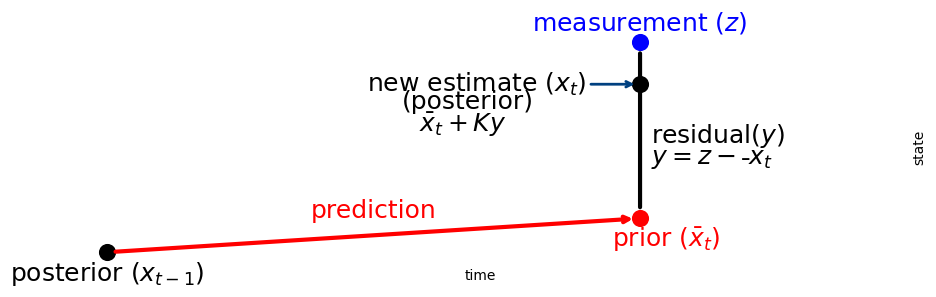

In [2]:
import lean.kf_book.book_plots as book_plots
book_plots.show_residual_chart()

单变量卡尔曼滤波器用单变量高斯表示状态。当然，多元卡尔曼滤波器将使用多元高斯滤波器来表示状态。我们在上一章中了解到，多元高斯使用向量表示均值，矩阵表示协方差。这意味着卡尔曼滤波器需要使用线性代数来执行估计。

我不希望你记住这些方程，但我在下面列出了单变量和多变量方程。它们非常相似。

<u>**预测**</u>

$\begin{array}{|l|l|l|}
\hline
\text{单变量} & \text{单变量} & \text{多元}\\
& \text{(卡尔曼形式)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

不用担心线性代数的细节，我们可以看到：

$\mathbf x,\, \mathbf P$ 是状态的均值和协方差。 它们对应于 $x$ and $\sigma^2$.

$\mathbf F$ 是 *状态转移矩阵*. 当与 $\bf x$ 相乘，它计算得到先验。

$\mathbf Q$ 过程模型的协方差矩阵. 它对应于 $\sigma^2_{f_x}$。

$\mathbf B$ and $\mathbf u$ 对我们来说是新的. 它允许我们对系统的控制输入进行建模。


<u>**更新**</u>

$\begin{array}{|l|l|l|}
\hline
\text{单变量} & \text{单变量} & \text{多元}\\
& \text{(卡尔曼形式)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ 是测量函数. 我们在本书中还没有见到过它，我会稍后解释它。如果你想象一下把 $\mathbf H$ f从方程中删除, 你应该能够看到这些方程也是相似的。

$\mathbf z,\, \mathbf R$ 是测量的均值和噪声协方差. 在单变量滤波器中，它对应单变量的 $z$ and $\sigma_z^2$ 。(我已经用 $x$ 代替了单变量方程的 $\mu$，以使符号尽可能相似)。

$\mathbf y$ and $\mathbf K$ 是残差和卡尔曼增益。

细节将会与单变量滤波器不同，因为它们是向量和矩阵。但是概念完全相同。

- 使用高斯来表示我们的状态的估计和误差
- 使用高斯来表示测量值和它的误差
- 使用高斯去表示过程模型
- 使用过程模型去预测下一个时间步的状态(先验估计)
- 根据测量和先验估计形成后验估计

作为设计师，你的工作是设计状态 $\left(\mathbf x, \mathbf P\right)$, 过程 $\left(\mathbf F, \mathbf Q\right)$, 测量 $\left(\mathbf z, \mathbf R\right)$, 和测量函数 $\mathbf H$. 如果系统有控制输入，比如机器人，你也将会设计 $\mathbf B$ and $\mathbf u$.

我已经将卡尔曼滤波器的方程编程为 predict 和 update 函数在FilterPy 模块中。您将使用以下命令导入它们：

```python
from filterpy.kalman import predict, update
```

## **跟踪狗**

让我们回到我们老生常谈的追踪狗的问题。这次我们将包括上一章的基本见解，并使用隐藏变量来改进我们的估计。我可以从数学开始，但让我们实现一个过滤器，边走边学。从表面上看，数学是不同的，也许比前几章更复杂，但想法都是一样的——我们只是多元高斯的乘法和加法。

我们首先编写一个狗的运动仿真。这个仿真将会运行count个步骤，在每个时间步中，它向前移动接近1m。在每个步骤中，速度将会根据过程方差process_var而变化。更新位置之后，我们获取一个测量值，假设传感器的方差是z_var。该函数返回一个numpy数组，一个是位置(先验)，一个是测量值。

In [3]:
import math
import numpy as np
from numpy.random import randn

# 模拟狗的运动和传感器测量
def compute_dog_data(z_var, process_var, count=1, dt=1.0):
    x, vel = 0.0, 1.0                               # 狗的初始位置和速度
    z_std = math.sqrt(z_var)                        # 传感器测量的标准差
    p_std = math.sqrt(process_var)                  # 过程模型的标准差
    
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)                 # 每个时刻的实际速度
        x += v * dt                                 # 每个时刻的实际位置
        
        xs.append(x)                                # 过程模型预测的狗的位置，先验估计
        zs.append(x + randn() * z_std)              # 传感器测量的狗的位置，证据或者可能性
        
    return np.array(xs), np.array(zs)

### **预测步骤**

对于预测，我们需要设计状态变量和它的协方差、过程模型和过程噪声，以及可选的控制输入。我们会按顺序处理它们。

#### **设计状态变量**

我们之前使用高斯在一个维度上跟踪狗的位置。均值 $(\mu)$表示最有可能的位置，方差($\sigma^2$)表示位置的概率分布。位置是系统的状态，我们称$\mu$ 为 *状态变量*。

在这个问题中，我们将跟踪狗的位置和速度。这要求我们去使用由状态向量$\mathbf x$以及相应的协方差矩阵$\mathbf P$表示的多元高斯。

状态变量要么是*观察变量*-由传感器直接测量，要么是由观察变量推断的*隐藏变量*。对于我们狗的跟踪问题，传感器仅仅测量位置信息，因此位置是观察变量、速度是隐藏变量。我们将很快学习如何跟踪隐藏变量。

重要的是要了解跟踪位置和速度是一种设计选择，其含义和假设我们尚未准备好探索。例如，我们还可以跟踪加速度，甚至是颠簸。现在，回想一下，在上一章中，我们展示了在协方差矩阵中包含速度会导致位置方差小得多。我们将在本章后面学习卡尔曼滤波器如何计算隐藏变量的估计值。

在单变量章节中，我们用标量值表示狗的位置（例如 $\mu=3.27$）。在上一章中，我们学习了对多个变量使用多元高斯。例如，如果我们想指定 10.0 m 的位置和 4.5 m/s 的速度，我们可以这样写：

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

卡尔曼滤波器是使用线性代数实现的。我们使用$n\times 1$的矩阵(称为一个*向量*)去存储$n$ 个状态变量。对于狗跟踪问题，我们使用 $x$ 表示位置，使用 $x$ 的一阶导数 $\dot x$ 表示速度。我使用牛顿的点符号来表示导数;$\dot x$ 表示 x 相对于 t 的一阶导数：$\dot x = \frac{dx}{dt}$。卡尔曼滤波方程使用 $\mathbf x$ 作为状态，因此我们将 $\mathbf x$ 定义为：

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

我们使用 $\mathbf x$ 而不是 $\mu$，但要认识到这是多元高斯的平均值。

另一种写法是$\mathbf x =\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$，因为行向量的转置是列向量。这种表示法在文本中更易于使用，因为它占用的垂直空间更小。

$\mathbf x$ 和位置 $x$ 巧合的具有相同的名称。如果我们在y轴方向对狗进行跟踪，我们会写 $\mathbf x =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$, 而不是  $\mathbf y =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$. $\mathbf x$ 在卡尔曼滤波器文献中是一个标准的状态变量名称。并且，我们不会改变它以赋予它更有意义的名称。这种命名的一致性有利于与同行之间的交流。

让我们对此进行编码，初始化 `x`非常简单。

In [4]:
# 狗的初始位置和速度
x = np.array([[10.0],
              [4.50]])
x

array([[10. ],
       [ 4.5]])

我经常在代码中使用转置将行矩阵转换为列向量，因为我发现输入和阅读更容易：

In [5]:
x = np.array([[10.0, 4.50]]).T
x

array([[10. ],
       [ 4.5]])

但是，NumPy 将 1D 数组识别为向量(列向量)，因此我可以使用 1D 数组简化此行。

In [6]:
x = np.array([10.0, 4.50])
x, x.shape

(array([10. ,  4.5]), (2,))

所有数组的元素具有相同的数据类型，通常是float和int类型。如果列表中所有元素的类型都是int，那么创建的array的数据类型也是int，否则的话，它将是float类型的数组。我经常为了方便会指定一个数字为浮点型。

In [7]:
np.array([1.0, 0, 0, 0, 0, 0])

array([1., 0., 0., 0., 0., 0.])

以下是一些示例。

In [8]:
A = np.array([[1, 2], [3, 4]])          # 维度是2*2
x = np.array([[10.0], [4.50]])          # 维度是2*1

# 矩阵乘法
print(np.dot(A, x))                     # 维度是2*1
print()

[[19.]
 [48.]]



在 Python 3.5+ 中，我们有矩阵乘法 @，其中`np.dot(A, B) == A @ B`。它可能比你可能意识到的有用性要小一些，因为它要求`A` 和 `B`都是数组。在本书的数学中，这些变量中的一些变量是标量，因此  @ 的有效性经常丢失。

In [9]:
# 可选择的矩阵乘法
print(A @ x)
print()

x = np.array([[10.0, 4.50]]).T
print(A @ x)
print()

# 默认就是个列向量
x = np.array([10.0, 4.50])
print(A @ x)
print()


[[19.]
 [48.]]

[[19.]
 [48.]]

[19. 48.]



最后一个返回一个 1D 数组，但我编写了卡尔曼滤波器类来处理这个问题。回想起来，这可能会导致混乱，但它确实有效。

#### **设计状态协方差**

状态高斯的另一半是协方差矩阵 $\mathbf P$。在单变量卡尔曼滤波器中，我们为 $\sigma^2$ 指定了一个初始值，然后滤波器负责在将测量值添加到滤波器时更新其值。同样的事情发生在多维卡尔曼滤波器中。我们为 $\mathbf P$ 指定一个初始值，过滤器在每个时间步去更新它。

我们需要将方差设置为合理的值。例如，如果我们相当不确信初始位置，我们可以设置 $\sigma_\mathtt{pos}^2=500 m^2$。狗的最高速度为21 m/s。因此，在缺乏任何其它信息时，我们对速度可以设置为$3\sigma_\mathtt{vel}=21$, or $\sigma_\mathtt{vel}^2=7^2=49$。

在上一章中，我们展示了位置和速度是相关的。但是，对于狗来说，它们的相关性如何？我们不知道。正如我们将看到的，过滤器会为我们计算这一点，因此我将协方差初始化为零。当然，如果你知道协方差，你应该使用它们。

回想一下，协方差矩阵的对角线包含每个变量的方差，非对角线元素包含协方差。因此，我们有：

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

我们可以使用 numpy.diag，它根据对角线的值创建一个对角矩阵。回想一下线性代数，对角矩阵是在非对角元素中具有零的矩阵。

In [10]:
# 状态变量的协方差矩阵
P = np.diag([500.0, 49.0])
P

array([[500.,   0.],
       [  0.,  49.]])

我本可以写：

In [11]:
P = np.array([[500., 0.],
              [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

我们完成了。我们将滤波器的状态表示为多元高斯，并在代码中实现。

#### **设计过程模型**


下一步是设计过程模型。它是一个描述系统行为的数学模型。滤波器使用它来预测离散时间步长后的状态。我们使用一组方程来描述系统动力学。

在单变量章节中，我们对狗的运动建模：

$$ x = v \Delta t + x_0$$

我们的实现如下：

```python
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, 
                    pos.var + movement.var)
```

在本章中，我们将做同样的事情，使用多元高斯而不是单变量高斯。您可能会想象这种实现：

$$ \mathbf x = \begin{bmatrix}5.4\\4.2\end{bmatrix}, \, \, 
\dot{\mathbf x} =  \begin{bmatrix}1.1\\0.\end{bmatrix} \\
\mathbf x = \dot{\mathbf x}t + \mathbf x$$

但我们需要对此进行总结。卡尔曼滤波方程适用于任何线性系统，而不仅仅是牛顿系统。也许您正在过滤的系统是化工厂中的管道系统，给定管道中的流量由不同阀门设置的线性组合决定。

$$\mathtt{pipe_1} = 0.134(\mathtt{valve}_1) + 0.41(\mathtt{valve}_2 - \mathtt{valve}_3) + 1.34$$
$$\mathtt{pipe_2} = 0.210(\mathtt{valve}_2) - 0.62(\mathtt{valve}_1 - \mathtt{valve}_5) + 1.86$$

线性代数有一种表达方程组的强大方法。拿这个系统：

$$\begin{cases}
2x+3y=8\\4x-y=2
\end{cases}$$

我们可以通过编写以下内容将其以矩阵形式表示：

$$\begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\2\end{bmatrix}$$

如果在此等式中执行[矩阵乘法]((https://en.wikipedia.org/wiki/Matrix_multiplication#General_definition_of_the_matrix_product))，则结果将是上面的两个等式。在线性代数中，我们会将其写为 $\mathbf{Ax}=\mathbf B$，其中

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf B=\begin{bmatrix}8\\2\end{bmatrix}$$

然后我们可以使用 SciPy 的包linalg来求解 $\mathbf x$：


In [12]:
from scipy.linalg import solve
A = np.array([[2, 3], [4, -1]])
b = np.array([[8], [2]])
x = solve(A, b)
x

array([[1.],
       [2.]])

我们使用过程模型来执行预测，因为方程告诉我们，当给定当前状态时，可以获取下一个状态。卡尔曼滤波器使用此线性方程来实现这一点。其中，$\mathbf{\bar x}$是先验估计，或预测状态。

$$\mathbf{\bar x} = \mathbf{Fx}$$

我们可以明确为

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

作为滤波器的设计者，我们的工作是指定$\mathbf F$ 以便于 $\bar{\mathbf x}  = \mathbf{Fx}$为我们的系统执行预测。为此，我们需要为每个状态变量提供一个方程。在我们的问题中$\mathbf x = \begin{bmatrix}x & \dot x\end{bmatrix}^\mathtt{T}$，所以我们需要一个方程计算位置 $x$，另一个方程用于计算速度 $\dot x$。我们已经知道了位置预测的方程：

$$\bar x = x + \dot x \Delta t$$

我们的速度方程是什么？我们没有预测模型来预测我们的狗的速度将如何随时间变化。在这种情况下，我们假设它在预测之间保持不变。当然，这并不完全正确，但只要速度在每次预测中变化不大，您就会看到过滤器的性能非常好。所以我们说

$$\bar{\dot x} = \dot x$$

这为我们系统提供了过程模型

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$

对于状态中的每一个变量，这里有一个正确的方程，隔离在左侧。我们需要用$\bar{\mathbf x}  = \mathbf{Fx}$形式表达这组方程。重新排列术语可以更轻松地查看要执行的操作。

$\bar{\mathbf x}  = \mathbf{Fx}$
$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

我们可以将其以矩阵形式重写为

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

$\mathbf F$ 被称为 *状态转换函数* 或者 *状态转移矩阵*。 在后面的章节中，它将是一个真正的函数，而不是一个矩阵，所以称它为函数更通用一些。

In [13]:
# 初始化状态转移矩阵
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

让我们测试一下！FilterPy模块有一个predict方法通过计算$\mathbf{\bar x} = \mathbf{Fx}$执行预测。让我们调用它，看看会发生什么。我们将位置设置为 10.0，速度设置为 4.5 米/秒。我们已经定义了dt = 0.1 ，这意味着时间步长为 0.1 秒，因此我们预料预测之后新位置为 10.45 米。速度应保持不变。

In [14]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])                       # 状态变量
P = np.diag([500, 49])                          # 状态变量协方差矩阵
F = np.array([[1, dt],
              [0, 1]])                          # 过程模型，状态转移矩阵

x, P = predict(x=x, P=P, F=F, Q=0)
print('x = ', x, 'P = ', P)

x =  [10.45  4.5 ] P =  [[500.49   4.9 ]
 [  4.9   49.  ]]


这奏效了。如果我们连续调用predict()几次，则每次都会更新该值。

In [15]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x = ', x)

x =  [10.9  4.5]
x =  [11.35  4.5 ]
x =  [11.8  4.5]
x =  [12.25  4.5 ]


predict()函数计算预测的均值和协方差。这是 𝐏 经过五次预测的值，我们在卡尔曼滤波方程中，用$\mathbf{\bar P}$ 表示。

In [16]:
print(P)

[[512.25  24.5 ]
 [ 24.5   49.  ]]


检查对角线元素的值，显示我们的位置方差变大了。在没有测量的情况下，我们已经进行了5次预测步骤，并且我们的不确定性增加了。非对角线元素变成了非零-卡尔曼滤波器检测到了位置和速度之间的相关性！速度的方差并没有改变。

在这里，我绘制了预测前后的协方差。初始值为纯红色，先验（预测）为黑色虚线。我更改了协方差和时间步长，以更好地说明更改。

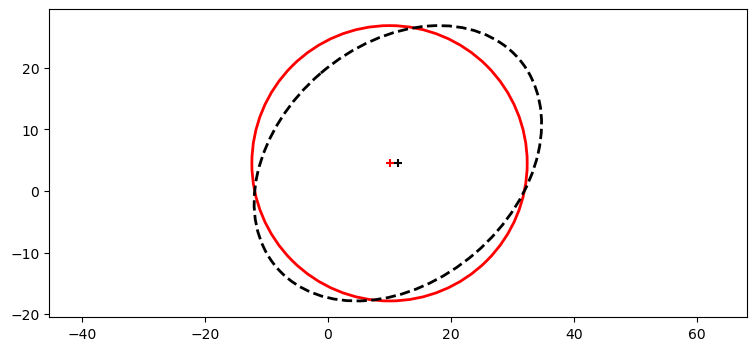

In [17]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

您可以看到椭圆的中心移动了少量（从 10 到 11.35），因为位置发生了变化。椭圆也拉长，显示了位置和速度之间的相关性。滤波器如何计算新值 $\mathbf{\bar P}$，它基于什么？请注意，我每次都将过程噪声`Q`设置为零，因此这不是由于我添加了噪声。现在讨论这个问题还为时过早，但回想一下，到目前为止，在每个过滤器中，预测步骤都会导致信息丢失。这里也是如此。一旦我们涵盖了更多的内容，我会给你细节。

#### **设计过程噪声**

快速回顾过程噪声。一辆汽车在打开巡航控制的情况下沿着道路行驶;它应该以恒定的速度行驶。我们对此进行建模 $\bar x_k=\dot x_k\Delta t + x_{k-1}$。但是，它受到许多未知因素的影响。巡航控制无法完美地保持恒定速度。风会影响汽车，山丘和坑洼也是如此。乘客摇下车窗，改变汽车的拖曳曲线。

$$\dot{\mathbf x} = f(\mathbf x) + w$$

其中 $f(\mathbf x)$ 对状态转换进行建模，并且 $w$ 是 *过程模型的白噪声*.

我们将在卡尔曼滤波数学一章中学习如何从一组微分方程到卡尔曼滤波矩阵。在本章中，我们利用了牛顿已经为我们推导出运动方程的事实。现在，您只需要知道我们通过添加过程噪声协方差矩阵来考虑系统中的噪声 𝐐到协方差 𝐏.我们不添加任何东西到𝐱，因为噪声是白色的 - 这意味着噪声的平均值将为 0。如果平均值为 0， 𝐱不会改变。

单变量的卡尔曼滤波器使用`variance = variance + process_noise`去计算预测步的方差。多元卡尔曼滤波器也做类似的事情，本质上就是`P = P + Q`。我之所以说“本质上”，是因为协方差方程中还有其他与噪声无关的项，我们将在后面看到。

推导过程噪声矩阵可能要求很高，我们将把它推迟到卡尔曼数学章节。现在知道 $\mathbf Q$ 等于白噪声的预期值$w$，计算方式为 $\mathbf Q = \mathbb E[\mathbf{ww}^\mathsf T]$。在本章中，我们将重点介绍修改此矩阵如何改变滤波器的行为。

对于本章的运动学问题，FilterPy 模块提供算函数去计算 $\mathbf Q$。`Q_discrete_white_noise`需要3个参数。`dim`, 指定了矩阵的维度, `dt`,是以秒为单位的时间步长,  `var`, 噪声的方差。简而言之，它在给定时间段内的噪声离散化，假设我们将在后面讨论。此代码计算以方差为 2.35、时间步长为 1 秒的白噪声$\mathbf Q$。

In [18]:
from filterpy.common import Q_discrete_white_noise

# 初始化过程噪声(白噪声)
Q = Q_discrete_white_noise(dim=2, dt=1, var=2.35)
print(Q)

[[0.588 1.175]
 [1.175 2.35 ]]


#### **设计控制函数**

卡尔曼滤波器不仅过滤数据，还允许我们去合并机器人和飞机等系统的控制输入。假设我们正在控制一个机器人。在每个时间步长，我们都会根据机器人的当前位置与期望位置向机器人发送转向和速度信号。卡尔曼滤波方程将这些知识整合到滤波方程中，根据当前速度和驱动电机的控制输入创建预测位置。请记住，我们从不丢弃信息。

对于线性系统，控制输入的影响可以描述为一组线性方程组，我们可以用线性代数将其表示为：

$$\Delta\mathbf x = \mathbf{Bu}$$

这里 $\mathbf u$ 是 *控制输入*, 并且 $\mathbf B$ 是 *控制输入模型* or *控制函数*. For example, $\mathbf u$ 可能是控制车轮电机转动速度的电压, 并且乘以 $\mathbf B$ 得到收益率 $\Delta[\begin{smallmatrix}x\\\dot x\end{smallmatrix}]$. 换句话说, 它必须计算由于控制输入而变化，$\mathbf x$ 改变了多少。

因此，针对先验均值，完整卡尔曼滤波方程为：

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$

这是调用 KalmanFilter.predict() 时计算的方程。

您的狗可能经过训练以响应语音命令。所有可用的证据表明我的狗没有任何控制输入，所以我设置 $𝐁$ 归零。在Python中，我们写：


In [19]:
# 我的狗不听我的命令
B = 0
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x = ', x)
print('P = ', P)

x =  [12.7  4.5]
P =  [[680.587 301.175]
 [301.175 502.35 ]]


设置 $\mathbf B$ and $\mathbf u$ 为零是不必要的，因为  `predict` 使用0作为默认值:


In [20]:
predict(x, P, F, Q)[0] == predict(x, P, F, Q, B, u)[0]
predict(x, P, F, Q)[1] == predict(x, P, F, Q, B, u)[1]

array([[ True,  True],
       [ True,  True]])

#### **预测：总结**

作为设计者，你的工作是设定下面这些矩阵：

* $\mathbf x$, $\mathbf P$: 状态和协方差
* $\mathbf F$,  $\mathbf Q$: 过程模型和噪声协方差
* $\mathbf{B,u}$: 可选, 控制矩阵 and 控制输入

### **更新步骤**

现在我们可以实现过滤器的更新步骤。您只需要再提供两个矩阵，它们很容易理解。

#### **设计测量函数**

卡尔曼滤波器在我们所谓的**测量空间**中计算更新步骤。我们在单变量章节中大多忽略了这个问题，因为它增加了复杂性。我们使用报告其位置的传感器跟踪狗的位置。计算残差很容易 - 从测量中减去滤波器的预测位置：

$$ \mathtt{residual} = \mathtt{measured\, \, position} - \mathtt{predicted\, \, position}$$

我们需要计算残差，因为我们按卡尔曼增益对其进行缩放以获得新的估计值。

如果我们尝试使用温度计跟踪温度，该温度计输出与温度读数相对应的电压，会发生什么？残差计算的方程将毫无意义;您不能从电压中减去温度。

$$ \mathtt{residual} = \mathtt{voltage} - \mathtt{temperature}\;\;\;(NONSENSE!)$$

我们需要将温度转换为电压，以便执行减法。对于温度计，我们可以这样写：

```python
CELSIUS_TO_VOLTS = 0.21475
residual = voltage - (CELSIUS_TO_VOLTS * predicted_temperature)
```

卡尔曼滤波器通过让您提供一个将状态转换为测量的测量函数来概括这个问题。

**我们为什么要在测量领域工作？为什么不在状态空间中通过将电压转换为温度来工作，从而使残差成为温度差异?**

我们不能这样做，因为大多数测量值都是不可逆的。跟踪问题的状态包含隐藏变量 $\dot x$ ，无法将位置测量转换为包含速度的状态。另一方面，将包含位置和速度的状态转换为仅包含位置的等效“测量”是微不足道的。我们必须在测量空间中工作，以使残差的计算成为可能。

测量 $\mathbf z$ 和状态 $\mathbf x$ 是向量，因此我们需要使用矩阵来执行转换。执行此步骤的卡尔曼滤波方程为：

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$

其中 $\mathbf y$ 是残差, $\mathbf{\bar x}$ 是先验, $\mathbf z$ 是测量值, and $\mathbf H$ 是测量函数(将状态映射到测量空间)。 所以我们去先验, 将其乘以 $\mathbf H$, 然后从测量值中减去。这给了我们在测量空间中测量值与预测的偏差。


<img src="lean/figs/residual_chart_with_h.png">

我们需要设计  $\mathbf H$ 以便于 $\mathbf{H\bar x}$ 产生测量值。对于这个问题，我们有一个测量位置的传感器，所以 $\mathbf z$ 将是拥有一个变量向量：

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

残差方程的形式为:

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$

$\mathbf H$ 必须是 1x2 维度的矩阵，因为 $\mathbf{Hx}$ 的维度是 1x1. 回想矩阵乘法， $m\times n$ 矩阵乘以 $n\times p$ 矩阵，产生$m\times p$ 维度的矩阵。

我们想要位置 $x$ 乘以 1 得到相应的位置的测量值。我们不需要使用速度来找到相应的测量值，因此我们将 $\dot x$ 乘以 0 。

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$

因此，对于我们的卡尔曼滤波器，我们设置：

$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

In [21]:
# 测量函数，将状态映射到测量空间
H = np.array([[1., 0.]])
H, H.shape

(array([[1., 0.]]), (1, 2))

我们已经设计了卡尔曼滤波器大部分内容。剩下的就是对传感器中的噪声进行建模。

#### **设计测量(Measurement)**

测量表示为$\mathbf z$，它是测量的平均值，$\mathbf R$是测量的协方差。

$\mathbf z$ 很容易。它包含所有的测量值为一个向量。我们仅仅有一个测量值，因此我们有：

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

如果我们有两个传感器或测量值，我们将有：

$$\mathbf z = \begin{bmatrix}z_1 \\ z_2\end{bmatrix}$$

测量噪声矩阵将传感器中的噪声建模为协方差矩阵。在实践中，这可能很困难。一个复杂的系统可能有许多传感器，它们之间的相关性可能不清楚，通常它们的噪声不是纯粹的高斯。例如，如果温度较高，则传感器可能会偏向于读取高读数，因此噪声在平均值的两侧分布不均匀。我们稍后将学习处理这些问题。

卡尔曼滤波方程使用协方差矩阵 $\mathbf R$ 表示测量噪声。矩阵的维度是 $m{\times}m$, 其中 $m$ 是传感器的数量。它是一个协方差矩阵，用于表示传感器之间的相关性。我们只有 1 个传感器，因此 $\mathbf R$ 是：

$$R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$

如果 $\sigma^2_z$ 是 5 m$^2$，我们会有 $R = \begin{bmatrix}5\end{bmatrix}$. 

如果我们有两个位置传感器，第一个位置传感器的方差为 5 m$^2$ ，第二个方差为 5 m$^2$ ，我们会写

$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

我们将方差放在对角线上，因为这是一个协方差矩阵，其中方差位于对角线上，协方差（如果有的话）位于非对角线元素中。在这里，我们假设两个传感器之间的噪声没有相关性，因此协方差为 0。

对于我们的问题，我们只有一个传感器，因此我们可以将其实现为：

In [22]:
# 传感器的噪声，测量噪声
R = np.array([[5.]])
R, R.shape

(array([[5.]]), (1, 1))

我们通过调用 update 来执行更新

In [23]:
from filterpy.kalman import update

z = 1.0
x, P = update(x, P, z, R, H)
print('x = ', x)

x =  [ 1.085 -0.64 ]


跟踪所有这些变量是很麻烦的，所以 FilterPy 模块也用KalmanFilter类实现了卡尔曼过滤器。我将在本书的其余部分使用该类，但我想让你们看到这些函数的过程形式，因为我知道你们中的一些人不是面向对象编程的粉丝。

## 实现卡尔曼滤波器

我已经为您提供了滤波器的所有代码，但现在让我们将其收集在一个地方。首先，我们构造一个`KalmanFilter`对象。我们必须用`dim_x`参数指定状态中的变量数,用`dim_z`指定测量值的数量。我们有两个状态变量和一个测量值。所以我们这样写：

```python
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
```
这将创建一个对象，其中包含所有卡尔曼滤波矩阵的默认值：

In [24]:
from filterpy.kalman import KalmanFilter

dog_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', dog_filter.x.T)                       # 状态变量初始值
print('R = ', dog_filter.R)                         # 传感器的方差
print('Q = \n', dog_filter.Q)                       # 过程模型的噪声协方差

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


现在，我们为我们的问题初始化了有效的矩阵和向量的值。我把它放在一个辅助函数中，以允许您为 `R`, `P`和 `Q`指定不同的初始值。我们将创建和运行其中的许多过滤器，这为我们节省了很多麻烦。

In [25]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    '''
        返回一个恒定速度模型的卡尔曼滤波器, 状态是[x dx].T
    '''
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]])                   # 位置和速度, 维度是[2, 1]
    kf.F = np.array([[1., dt],
                     [0, 1]])                       # 状态转移矩阵, 维度是[2, 2]
    
    kf.H = np.array([[1., 0]])                      # 测量函数, 维度是[1, 2]
    kf.R *= R                                       # 测量的不确定性, 维度是[1, 1]
    
    if np.isscalar(P):
        kf.P *= P                                   # 状态的协方差矩阵
    else:
        kf.P[:] = P                                 # [:] 表示深拷贝
        
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)          # 过程模型噪声
    else:
        kf.Q[:] = Q
        
    return kf

`KalmanFilter` 初始化 `R`, `P`, 和 `Q` 为单位矩阵, 因此`kf.P *= P`是一种快速指派所有对角线元素为相同的标量的方法。现在，我们创建滤波器：

In [26]:
dt = 0.1
x = np.array([0., 0.])
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

您可以通过在命令行上输入变量来检查筛选器所有属性的当前值。

In [27]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[0.    0.   ]
     [0.    0.001]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7f846931dd30>

剩下的就是编写代码来运行卡尔曼滤波器。

In [28]:
from lean.kf_book.mkf_internal import plot_track

def run(x0=(0., 0.), P=500, R=0, Q=0, dt=1.0, track=None, zs=None, count=0, do_plot=True, **kwargs):
    '''
        track是狗的实际位置, zs是相应的测量值。
    '''
    # 如果没有数据提供,模拟狗的运动
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)               # 狗的实际位置和测量位置
    
    # 创建一个卡尔曼滤波器
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)
    
    # 运行卡尔曼滤波器, 并且存储结果
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)                     # 后先验估计值
        cov.append(kf.P)                    # 后验估计的协方差
        
    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov
    

这是滤波器的完整代码，其中大部分是样板代码。我已经使它足够灵活，以支持本章中的多种用途，所以它有点冗长。让我们逐行完成它。

第一行检查您是否在数据中提供了测量数据。如果没有，它使用我们之前编写的compute_dog_data函数创建数据。

接下来的几行使用我们的辅助函数来创建卡尔曼滤波器。

```python
# create the Kalman filter
 kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)
```

我们需要做的就是对每次测量执行卡尔曼滤波器的更新和预测步骤。`KalmanFilter`类提供了两种方法`predict()`和`update()`，并用于此目的。 `update()`h函数执行卡尔曼滤波器的测量更新步骤，并且它需要一个包含传感器测量值的变量。

如果没有存储结果的工作，循环读取：

```python
    for z in zs:
        kf.predict()
        kf.update(z)
```

每次调用 `predict` and `update` 去修改状态变量 `x` and `P`. 因此, 调用 `predict`之后, `kf.x` 是先验估计. 调用`update`之后, `kf.x` 就是后验估计. `data` 包含了狗的实际位置和测量位置, 因此我们使用 `[:, 1]` 获取测量值数组。

它真的没有比这更简单的了。当我们解决更复杂的问题时，此代码将基本保持不变;所有的工作都用于设置`KalmanFilter`矩阵; 执行滤波器是微不足道的。

代码的其余部分可以选择绘制结果，然后返回保存的状态和协方差。

让我们运行它。我们有 50 个测量值，噪声方差为 10，过程方差为 0.01。

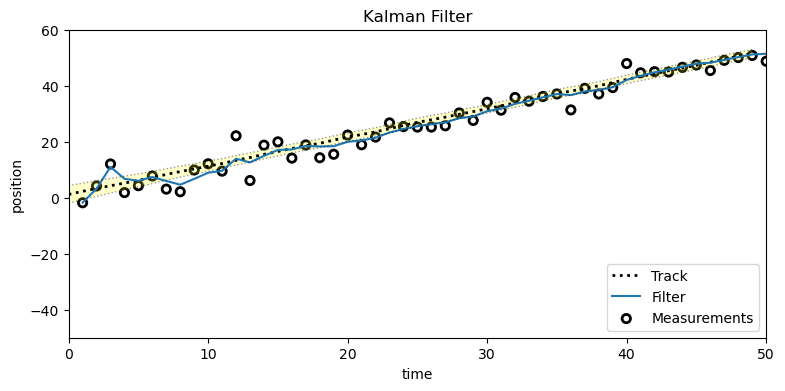

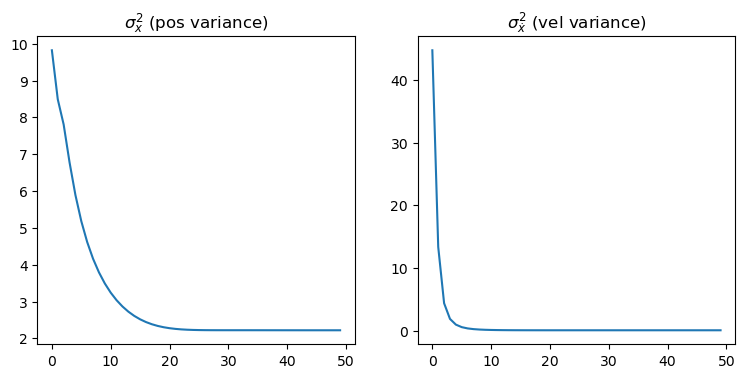

In [29]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

还有很多东西需要学习，但我们已经使用与鲁道夫·卡尔曼相同的理论和方程实现了卡尔曼滤波器！在你的GPS、客机、机器人等内部运行的代码与此很像。

第一个图将卡尔曼滤波器的输出与测量值和我们的狗的实际位置（标记为 Track）绘制。在初始值设置一段时间之后，滤波器的输出应该与狗的实际位置非常接近。黑色虚线之间的黄色阴影部分显示了滤波器方差的 1 个标准差，我将在下一段中对此进行解释。

接下来的两个图显示了 $x$ 和 $\dot x$的方差。 我已经绘制了 $\mathbf P$ 对角线元素随时间的变化。 回想一下，协方差矩阵的对角线包含了每一个状态变量的方差。 因此 $\mathbf P[0,0]$ 是 $x$ 的方差,  $\mathbf P[1,1]$ 是 $\dot x$ 的方差。 你可以看到它们的方差快速收敛到很小。

协方差矩阵 $\mathbf P$ 告诉我们滤波器的理论性能，假设我们告诉它的一切都是真的。回想一下，标准差是方差的平方根，大约 68% 的高斯分布发生在一个标准差内。如果至少68%的滤波器输出在一个标准偏差范围内，则滤波器可能表现良好。在上面的图表中，我将一个标准差显示为两条虚线之间的黄色阴影区域。在我看来，过滤器似乎略微超出了该范围，因此过滤器可能需要一些调整。

在单变量章节中，我们用比上面的代码简单得多的代码过滤了非常嘈杂的信号。但是，请注意，现在我们正在处理一个非常简单的示例 - 一个在一维空间和一个传感器中移动的物体。这大约是我们可以使用上一章中的代码计算的极限。相反，我们可以使用此代码实现非常复杂的多维过滤器，只需更改对过滤器变量的赋值即可。也许我们想在经济模型中跟踪 100 个维度。或者我们有一架带有GPS，INS，TACAN，雷达高度计，气压高度计和空速指示器的飞机，我们希望将所有这些传感器集成到一个模型中，以预测3D空间中的位置，速度和加速度。我们可以使用本章中的代码来做到这一点。

我想让你更好地了解高斯如何随时间变化，所以这里有一个3D图，显示了高斯每隔7个epoch（时间步长）。每 7 个epoch将它们分开足够多，因此可以独立看到每个。第一个高斯在 t=0时刻，它在左边。

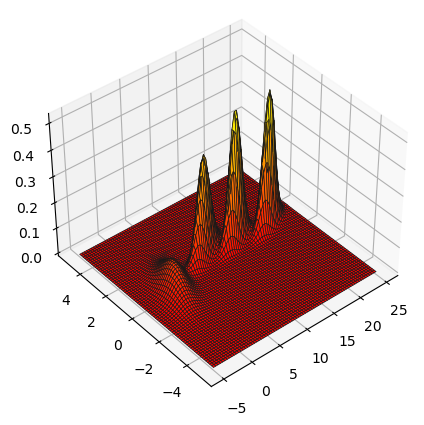

In [33]:
from lean.kf_book.book_plots import set_figsize, figsize
from lean.kf_book.nonlinear_plots import plot_gaussians

P = np.diag([3., 1.])
np.random.seed(3)

Ms, Ps = run(count=25, R=10, Q=0.01, P=P, do_plot=False)
with figsize(x=9, y=5):
    plot_gaussians(Ms[::7], Ps[::7], (-5,25), (-5, 5), 75)

### **Saver类**


在run()方法中，我编写了样板代码来保存过滤器的结果。

```python
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
```

有一种简单的方法可以避免这种情况。filtery.common 模块提供了 Saver 类，每次调用Saver.save()时，将保存卡尔曼滤波器类中的所有属性。让我们看看它的实际效果，然后我们将更多地讨论它。


In [34]:
from filterpy.common import Saver

kf = pos_vel_filter([0., 0.1], R=R, P=P, Q=Q, dt=1.)

s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()                                        # 保存当前状态

Saver对象现在包含卡尔曼过滤器对象的所有属性的列表。kf.x是筛选器的当前状态估计值。因此，s.x包含了循环内计算的已保存状态估计值：

In [35]:
s.x

[array([0.531, 0.304]),
 array([1.555, 0.763]),
 array([2.784, 1.036]),
 array([3.944, 1.105]),
 array([5.015, 1.086])]

您可以使用keys属性查看所有可用属性：

In [37]:
s.keys

['alpha',
 'likelihood',
 'log_likelihood',
 'mahalanobis',
 'dim_x',
 'dim_z',
 'dim_u',
 'x',
 'P',
 'Q',
 'B',
 'F',
 'H',
 'R',
 '_alpha_sq',
 'M',
 'z',
 'K',
 'y',
 'S',
 'SI',
 '_I',
 'x_prior',
 'P_prior',
 'x_post',
 'P_post',
 '_log_likelihood',
 '_likelihood',
 '_mahalanobis',
 'inv']

这里有许多属性我们还没有讨论过，但很多应该很熟悉。

此时，您可以编写代码来绘制这些变量中的任何一个。但是，`np.array`通常更有用，而不是`list`。调用`Saver.to_array()`会将列表转换为`np.array` 。有一个警告：如果任何属性的形状在运行过程中发生变化，将引发异常，因为要求所有元素的类型和大小相同。

如果您再次查看keys属性，您会发现`z`是选择之一。这是有希望的;显然，测量值`z`是为我们保存的。让我们绘制它(测量值)和估计值(后验估计,滤波之后的值)。

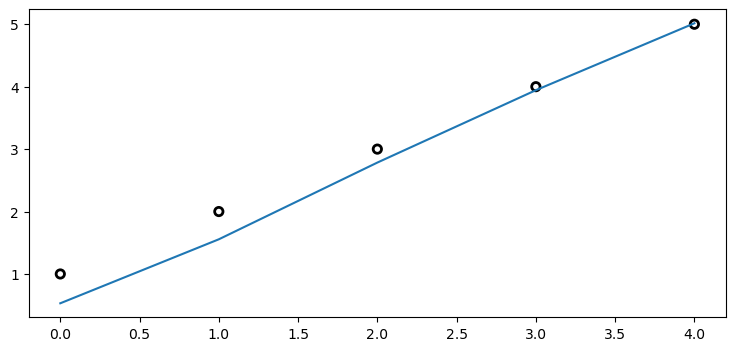

In [38]:
import matplotlib.pyplot as plt

s.to_array()
book_plots.plot_measurements(s.z)
plt.plot(s.x[:, 0])

虽然我已经在KalmanFilter类中演示了这一点，但它将适用于FilterPy实现的所有过滤器类。它也可能与您编写的任何类一起使用，因为它会检查对象以检索属性名称。我们将在整本书中使用这个类，以保持代码的可读性和简短性。使用 Saver 会减慢您的代码速度，因为幕后发生了很多事情，但对于学习和探索来说，便利性是无与伦比的。

## **卡尔曼滤波方程**
